# Решение второго пункта практического задания 

## Импорт

In [1]:
from model import *
from utils import __forward, compare, __find_face, __calculate_embedding, __calculate_cosine

In [175]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import numpy as np
from typing import Dict, Any
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, f1_score
import seaborn as sns
from ood_metrics import fpr_at_95_tpr

## Идея модернизации модели

Добавим в исходную модель **классификатор**, который булет определять изображение к одной из двух категорий: **0 - OOD пример, 1 - ID пример**.

Идея реализована при помощи добавления полносвязного слоя, а также конкатенации его выхода с выходом исходной модели. Выход модернизированной модели представляет собой вектор размерности 129, последний элемент которого - коэффициент уверенности.

На этапе обучения применялась технология **transfer learning**.

**ВАЖНОЕ ЗАМЕЧАНИЕ!** Для удобства тестирования разультатов второго пункта практического задания после описания процесса обучения модели был создан раздел **ЗАГРУЗКА НОВОЙ МОДЕЛИ ДЛЯ УДОБСТВА ТЕСТИРОВАНИЯ**. Данный пункт загружает полученные в результате обучения веса в модернизированную модель и позволит в дальнейшем выполнять код следующих пунктов.

## Подготовка датасета

Объем собранного датасета - 346206 изображений, принадлежащих к двум классам. 
К классу 1 относятся ID примеры - изображения лиц, черты которых хорошо различимы. 
К классу 0 относятся OOD примеры - изображения лиц в плохом качестве и изображения, не содержащие лиц.

**ВАЖНОЕ ЗАМЕЧАНИЕ!** Датасет из всех фотографий находился в папке train, однако в архив с решением задания датасет не был включен с целью минимизировать вес архива. На данный момент папка train содержит в себе всего несколько фотографий, чтобы отобразить структуру датасета.  

### Добавление шума 

Добавим гауссовский шум на некоторые изображения из OOD категории

In [10]:
path = 'train/0'
filelist=os.listdir('train/0')

for i in range(0, len(filelist), 40):
    img = cv2.imread('train/0/'+ filelist[i])

    mean = 0
    stddev = 180
    noise = np.zeros(img.shape, np.uint8)
    cv2.randn(noise, mean, stddev)

    noisy_img = cv2.add(img, noise)
    cv2.imwrite(os.path.join(path, 'noisy'+ filelist[i]), noisy_img)
    os.remove('train/0/'+filelist[i])
    
print('done')


done


## Собираем датасет

Размер батча - 32 изображения, размер изображений - 160х160, 20% всех изображений отведем под валидацию.

In [12]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)
train_dataset = tf.keras.utils.image_dataset_from_directory(
  "train",
  validation_split=0.2,
  subset="training",
  shuffle = True,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
  "train",
  validation_split=0.2,
  subset="validation",
  shuffle = True,
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 346206 files belonging to 2 classes.
Using 276965 files for training.
Found 346206 files belonging to 2 classes.
Using 69241 files for validation.


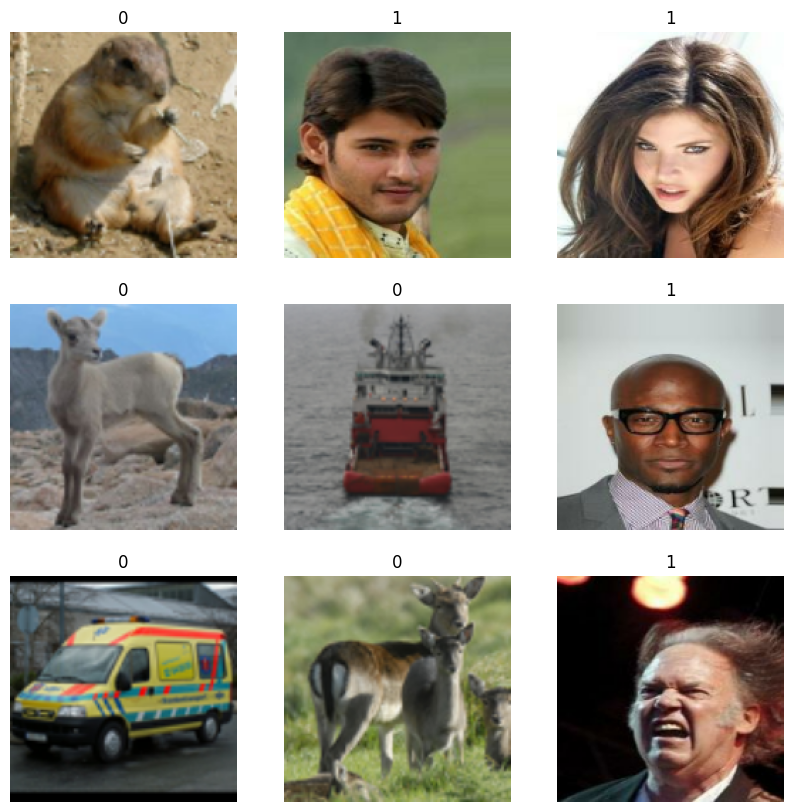

In [14]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Отведем часть изображений под тест

In [15]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1732
Number of test batches: 432


In [16]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## Аугментация данных
Создадим слой аугментации данных, который впоследствии включим в новую модель.

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

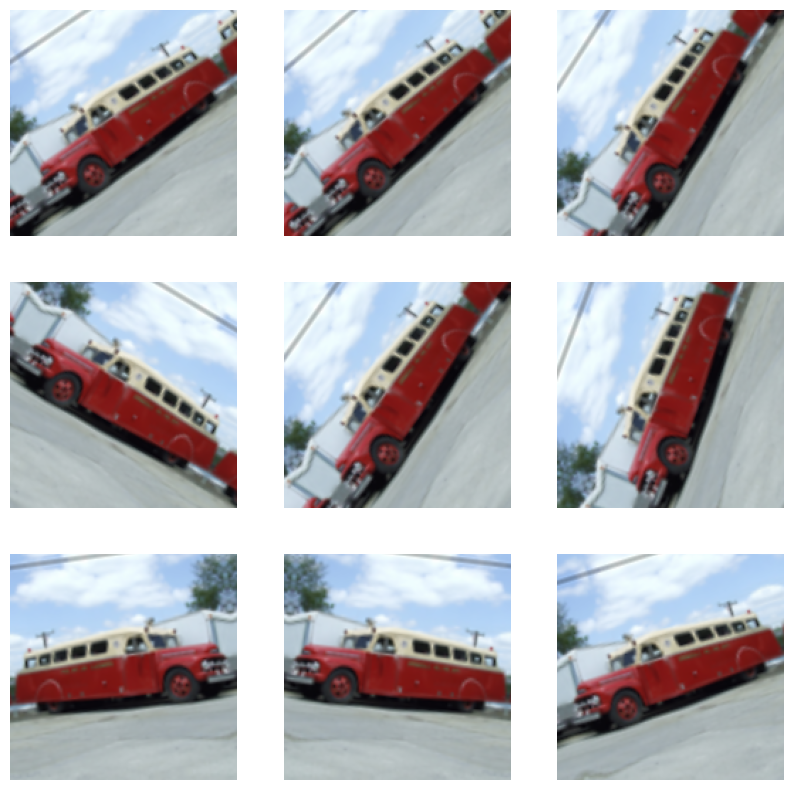

In [18]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Подгружаем исходную модель

In [19]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = load_model()

In [20]:
base_model.summary()

Model: "inception_resnet_v1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_1a_3x3 (Conv2D)        │ (None, 79, 79, 32)        │             864 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_1a_3x3_BatchNorm       │ (None, 79, 79, 32)        │              96 │ Conv2d_1a_3x3[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_1a_3x3_Activation      │ (None, 79, 79, 32)        │               0 │ Conv2d_1a_3x3_BatchNorm[0… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_2a_3x3 (Conv2D)        │ (None, 77, 77, 32)        │           9,216 │ Conv2d_1a_3x3_Activation[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_2a_3x3_BatchNorm       │ (None, 77, 77, 32)        │              96 │ Conv2d_2a_3x3[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_2a_3x3_Activation      │ (None, 77, 77, 32)        │               0 │ Conv2d_2a_3x3_BatchNorm[0… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_2b_3x3 (Conv2D)        │ (None, 77, 77, 64)        │          18,432 │ Conv2d_2a_3x3_Activation[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_2b_3x3_BatchNorm       │ (None, 77, 77, 64)        │             192 │ Conv2d_2b_3x3[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_2b_3x3_Activation      │ (None, 77, 77, 64)        │               0 │ Conv2d_2b_3x3_BatchNorm[0… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ MaxPool_3a_3x3 (MaxPooling2D) │ (None, 38, 38, 64)        │               0 │ Conv2d_2b_3x3_Activation[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_3b_1x1 (Conv2D)        │ (None, 38, 38, 80)        │           5,120 │ MaxPool_3a_3x3[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_3b_1x1_BatchNorm       │ (None, 38, 38, 80)        │             240 │ Conv2d_3b_1x1[0][0]        │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Conv2d_3b_1x1_Activation      │ (None, 38, 38, 80)        │               

 Total params: 22,808,144 (87.01 MB)

 Trainable params: 22,779,312 (86.90 MB)

 Non-trainable params: 28,832 (112.62 KB)

In [21]:
# 160*160*3 -> 128
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 128)


### Заморозка исходной модели
Чтобы избежать потерю уже предобученных весов, которые даны по усол, при обучении модернизированной модели, слои базовой модели, которая будет включена в модифицированную, должны быть заморожены

In [34]:
base_model.trainable = False

## Построение новой модели

Добавим слой аугментации данных.
Основой послежит исходная модель.
Добавим полносвязный слой `y = Dense(1, activation = "sigmoid", name = "Confidence")(x)` с выходным вектором размерности один (скаляр). Этот слой отвечает за кэффициент уверенности.

На время обучения изменим формат выхода модели, впоследствии при помощи конкатенации добавим параметр уверенности в выход модернизирвоанной модели.

In [23]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
y = Dense(1, activation = "sigmoid", name = "Confidence")(x)
#x = Concatenate(name = "With_confidence")([x, y])

new_model = tf.keras.Model(inputs, y)



In [24]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ inception_resnet_v1 (Functional)     │ (None, 128)                 │      22,808,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Confidence (Dense)                   │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,808,273 (87.01 MB)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 22,808,144 (87.01 MB)

Итого 129 параметров для обучения

## Компиляция

In [25]:
base_learning_rate = 0.0001
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5, name='accuracy')])

## Train
Проведем обучение на десяти эпохах

In [18]:
initial_epochs = 10

loss0, accuracy0 = new_model.evaluate(validation_dataset)

1732/1732 ━━━━━━━━━━━━━━━━━━━━ 231s 131ms/step - accuracy: 0.3286 - loss: 1.0312


In [19]:
history = new_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1953s 225ms/step - accuracy: 0.6211 - loss: 0.6635 - val_accuracy: 0.8393 - val_loss: 0.4072
Epoch 2/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1368s 158ms/step - accuracy: 0.8075 - loss: 0.4401 - val_accuracy: 0.8486 - val_loss: 0.3756
Epoch 3/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1377s 159ms/step - accuracy: 0.8171 - loss: 0.4186 - val_accuracy: 0.8519 - val_loss: 0.3648
Epoch 4/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1389s 160ms/step - accuracy: 0.8214 - loss: 0.4102 - val_accuracy: 0.8539 - val_loss: 0.3586
Epoch 5/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1385s 160ms/step - accuracy: 0.8229 - loss: 0.4041 - val_accuracy: 0.8555 - val_loss: 0.3538
Epoch 6/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1395s 161ms/step - accuracy: 0.8237 - loss: 0.4036 - val_accuracy: 0.8567 - val_loss: 0.3509
Epoch 7/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1401s 162ms/step - accuracy: 0.8242 - loss: 0.4029 - val_accuracy: 0.8565 - val_loss: 0.3521
Epoch 8/10
8656/8656 ━━━━━━━━━━━━━━━━━━━━ 1442s 167ms/s

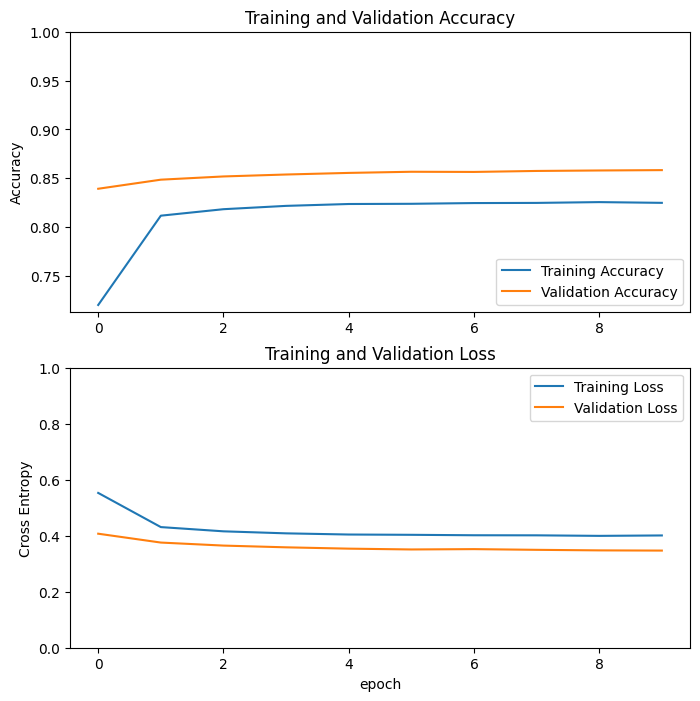

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Сохраним веса


In [25]:
new_model.save_weights('saved/after_first_train.weights.h5')

## Тест


In [59]:
loss, accuracy = new_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

432/432 ━━━━━━━━━━━━━━━━━━━━ 58s 135ms/step - accuracy: 0.8616 - loss: 0.3442
Test accuracy : 0.8616898059844971


[0.93680185 0.8863319  0.9039136  0.5958093  0.99248844 0.8294042
 0.14086024 0.43917632 0.81615305 0.01716057 0.03588647 0.97445136
 0.83803535 0.10213177 0.59822327 0.04114254 0.28826404 0.42950383
 0.15530945 0.9518407  0.90027934 0.13638186 0.03510776 0.24265344
 0.21853781 0.4026395  0.00405036 0.580204   0.38420334 0.9637733
 0.75185114 0.10213325]
Predictions:
 [0.93680185 0.8863319  0.9039136  0.5958093  0.99248844 0.8294042
 0.14086024 0.43917632 0.81615305 0.01716057 0.03588647 0.97445136
 0.83803535 0.10213177 0.59822327 0.04114254 0.28826404 0.42950383
 0.15530945 0.9518407  0.90027934 0.13638186 0.03510776 0.24265344
 0.21853781 0.4026395  0.00405036 0.580204   0.38420334 0.9637733
 0.75185114 0.10213325]


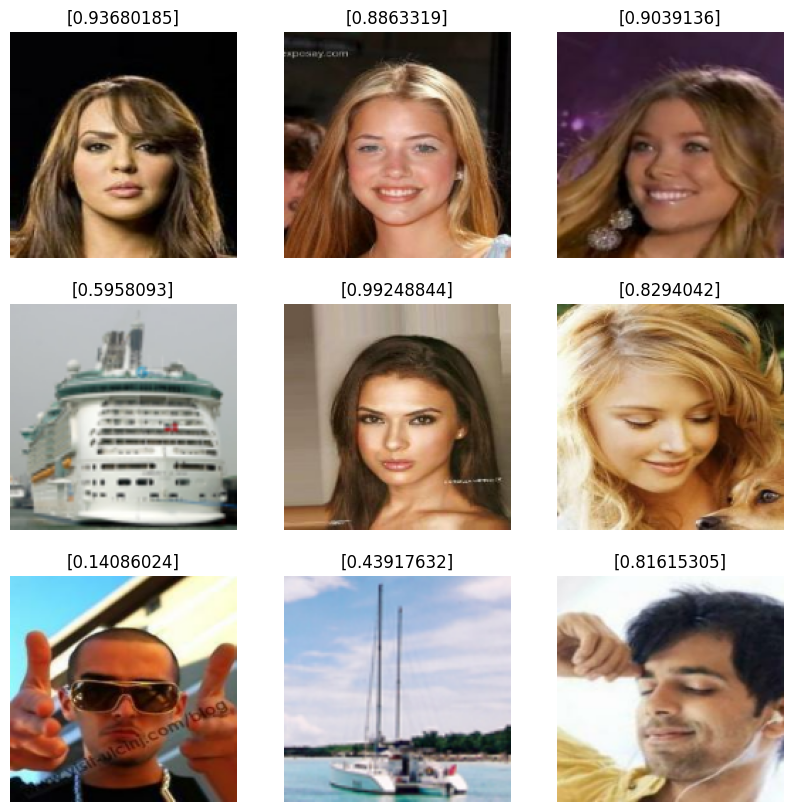

In [87]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = new_model.predict_on_batch(image_batch).flatten()
print(predictions)

#predictions = tf.where(predictions < 0.5, 0, 1)
predictions = tf.convert_to_tensor(predictions)


print('Predictions:\n', predictions.numpy())
#print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  #plt.title(class_names[predictions[i]])
  plt.title([predictions[i].numpy()])
  plt.axis("off")

## Добавляем слой конкатенации в модель и загружаем веса

In [35]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
y = Dense(1, activation = "sigmoid", name = "Confidence")(x)
x = Concatenate(name = "With_confidence")([x, y])

new2_model = tf.keras.Model(inputs, x)


In [36]:
new2_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 160, 160, 3)       │               0 │ input_layer_8[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ inception_resnet_v1           │ (None, 128)               │      22,808,144 │ sequential[2][0]           │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Confidence (Dense)            │ (None, 1)                 │             129 │ inception_resnet_v1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ With_confidence (Concatenate) │ (None, 129)               │               0 │ inception_resnet_v1[0][0], │
│                               │                           │                 │ Confidence[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 22,808,273 (87.01 MB)

 Trainable params: 129 (516.00 B)

 Non-trainable params: 22,808,144 (87.01 MB)

In [37]:
new2_model.load_weights('saved/after_first_train.weights.h5')

## ЗАГРУЗКА НОВОЙ МОДЕЛИ ДЛЯ УДОБСТВА ТЕСТИРОВАНИЯ

Загрузим полученные в результате обучения веса в модернизированную модель `new_model`, что позволит в дальнейшем выполнять код следующих пунктов.

In [1]:
from model import *
from utils import __forward, compare, __find_face, __calculate_embedding, __calculate_cosine

In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import cv2
import numpy as np
from typing import Dict, Any
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, f1_score
import seaborn as sns
from ood_metrics import fpr_at_95_tpr

In [3]:
base_model = load_model()

In [4]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [5]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = base_model(x, training=False)
y = Dense(1, activation = "sigmoid", name = "Confidence")(x)
x = Concatenate(name = "With_confidence")([x, y])

new_model = tf.keras.Model(inputs, x)

In [6]:
new_model.load_weights('saved/after_first_train.weights.h5')

In [7]:
new_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)    │ (None, 160, 160, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sequential (Sequential)       │ (None, 160, 160, 3)       │               0 │ input_layer_2[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ inception_resnet_v1           │ (None, 128)               │      22,808,144 │ sequential[0][0]           │
│ (Functional)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ Confidence (Dense)            │ (None, 1)                 │             129 │ inception_resnet_v1[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ With_confidence (Concatenate) │ (None, 129)               │               0 │ inception_resnet_v1[0][0], │
│                               │                           │                 │ Confidence[0][0]           │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 22,808,273 (87.01 MB)

 Trainable params: 22,779,441 (86.90 MB)

 Non-trainable params: 28,832 (112.62 KB)

## Проверка качества модели

### Вспомогательный этап: cохраним векторные представления изображений из id_samples на диск для ускорения работы новой модели

In [40]:
filelist=os.listdir('id_samples')
for i in range(len(filelist)):  
    c = __calculate_embedding(new_model, "id_samples/"+filelist[i]) 
    path = 'id_samples_new_arrays/' + filelist[i][:-4]+ '.npy'
    np.save(path, c)
print('done')

done


### Создадим инструменты работы с новой моделью
1) `new_compare(model: Model, img1_path: str, img2_path: str)` - сравнивает два изображения при помощи `__calculate_embedding(model: Model, img_path: str)` и `__calculate_cosine(emb1, emb2)`, а также возвращает коэффициенты уверенности для двух изображений,
2) `new_compare_emb(model: Model, img1_path: str, img2_path: str)` - аналогична функции `new_compare(model: Model, img1_path: str, img2_path: str)`, однако работает с уже посчитанными векторными представлениями изображений,
3)  `get_conf(model: Model, img_path: str)` - возвращает коэффициент уверенности в векторе признаков входного изображения.

Порог принадлежности примера ID или OOD будем определять в ходе дальнейших экспериментов, поэтому данные функции в дальнейшем будут модернизированы с учетом найденного порога.

In [8]:
def new_compare(model: Model, img1_path: str, img2_path: str) -> Dict[str, Any]:
    emb1 = __calculate_embedding(new_model, img1_path)
    emb2 = __calculate_embedding(new_model, img2_path)
    conf1 = emb1[-1]
    conf2 = emb2[-1]
    conf = conf1*conf2
    nemb1= emb1[:-1]
    nemb2= emb2[:-1]
    
    distance = __calculate_cosine(nemb1, nemb2)
    return {"confidence": min(conf1,conf2), "distance": distance, "equal": distance <= 0.4}

def new_compare_emb(model: Model, img1_path: str, img2_path: str) -> Dict[str, Any]:
    emb1 = np.load(img1_path)
    emb2 = np.load(img2_path)
    conf1 = emb1[-1]
    conf2 = emb2[-1]
    conf = conf1*conf2
    nemb1= emb1[:-1]
    nemb2= emb2[:-1]
    
    distance = __calculate_cosine(nemb1, nemb2)
    return {"confidence": min(conf1,conf2), "distance": distance, "equal": distance <= 0.4}

def get_confidence(model: Model, img_path: str) -> Dict[str, Any]:
    emb = __calculate_embedding(model, img_path)
    conf = emb[-1]
    return {"confidence": conf}

#### Примеры работы новых инструментов

In [9]:
i1, i2 = "id_samples/Abbas_Kiarostami_1.jpg", "id_samples/Abbas_Kiarostami_2.jpg"
c = new_compare(new_model, i1, i2)
c

{'confidence': 0.34940255, 'distance': 0.43512165546417236, 'equal': False}

In [10]:
i1, i2 = "id_samples_new_arrays/Abbas_Kiarostami_1.npy", "id_samples_new_arrays/Abbas_Kiarostami_2.npy"
c = new_compare_emb(new_model, i1, i2)
c

{'confidence': 0.34940255, 'distance': 0.43512165546417236, 'equal': False}

In [11]:
i1 = "id_samples/Abbas_Kiarostami_1.jpg"
g = get_confidence(new_model, i1)
g

{'confidence': 0.62777764}

### Проверим качество детекции OOD примеров

#### Сохраним в текстовый файл предсказания коэффициента уверенности новой модели на наборе, сформированном в ходе выполнения пункта 1 задания

In [41]:
filelist=os.listdir('OOD')
f = open('OOD_conf.txt', 'w')
for i in range(len(filelist)):
    g = get_confidence(new_model, 'OOD/'+filelist[i])
    f.write(filelist[i] + '\t' + str(g['confidence']) + '\n')
print('done')
f.close()

done


#### Сохраним в текстовый файл предсказания коэффициента уверенности новой модели на 60-и изображениях из id_samples

In [116]:
filelist=os.listdir('id_samples')
f = open('ID_conf.txt', 'w')
k = 0
for i in range(0, len(filelist), 2):
    g = get_confidence(new_model, 'id_samples/'+filelist[i])
    f.write(filelist[i] + '\t' + str(g['confidence']) + '\n')
    k += 1
    if k == 60:
        break
print('done')
f.close()

done


#### Отобразим результаты классификации

In [12]:
df_OOD = pd.read_csv('OOD_conf.txt', sep='\t', header=None)

df_OOD.columns = ['photo', 'pred']


df_OOD['label'] = df_OOD.apply(lambda row: 0, axis=1)

df_OOD

,photo,pred,label
0,Abbas_Kiarostami_1OOD.jpg,0.313309,0
1,Abbas_Kiarostami_2OOD.jpg,0.290995,0
2,asphalt_OOD.jpg,0.233327,0
3,bear_OOD.jpg,0.189779,0
4,Bernard_Lord_1OOD.jpg,0.262814,0
5,Bernard_Lord_2OOD.jpg,0.264964,0
6,bread_OOD.jpg,0.327845,0
7,cake_OOD.jpg,0.290203,0
8,Calista_Flockhart_1OOD.jpg,0.848630,0
9,Calista_Flockhart_2OOD.jpg,0.250604,0


In [13]:
df_ID = pd.read_csv('ID_conf.txt', sep='\t', header=None)

df_ID.columns = ['photo', 'pred']


df_ID['label'] = df_ID.apply(lambda row: 1, axis=1)

df_ID

,photo,pred,label
0,Abbas_Kiarostami_1.jpg,0.627778,1
1,Abbas_Kiarostami_3.jpg,0.301085,1
2,Abdullah_al-Attiyah_2.jpg,0.446418,1
3,Abdullah_Gul_1.jpg,0.670155,1
4,Abdullah_Gul_3.jpg,0.986586,1
5,Adel_Al-Jubeir_2.jpg,0.464436,1
6,Adrian_McPherson_1.jpg,0.352978,1
7,Adrian_McPherson_3.jpg,0.339181,1
8,Afton_Smith_2.jpg,0.519918,1
9,Aishwarya_Rai_1.jpg,0.831278,1


In [14]:
df = pd.concat([df_OOD, df_ID], ignore_index=True)
df

,photo,pred,label
0,Abbas_Kiarostami_1OOD.jpg,0.313309,0
1,Abbas_Kiarostami_2OOD.jpg,0.290995,0
2,asphalt_OOD.jpg,0.233327,0
3,bear_OOD.jpg,0.189779,0
4,Bernard_Lord_1OOD.jpg,0.262814,0
...,...,...,...
115,Benjamin_Netanyahu_1.jpg,0.937901,1
116,Benjamin_Netanyahu_3.jpg,0.644203,1
117,Ben_Curtis_2.jpg,0.341199,1
118,Bernard_Lord_1.jpg,0.956191,1


#### Риусем ROC кривую, находим оптимальный порог

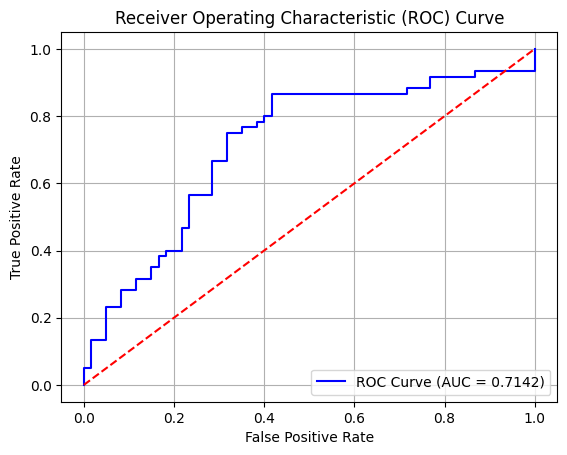

ROC AUC: 0.7142


In [15]:
fpr, tpr, thresholds = roc_curve(df['label'], df['pred'])

roc_auc = roc_auc_score(df['label'], df['pred'])

plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


print(f'ROC AUC: {roc_auc:.4f}')


#### True Positive Rate, False Positive Rate

In [16]:
fpr, tpr, thresholds = roc_curve(df['label'], df['pred'])

desired_fpr = 0.1 

optimal_idx = np.where(fpr <= desired_fpr)[0]  
optimal_threshold_idx = optimal_idx[np.argmax(tpr[optimal_idx])]  
optimal_threshold = thresholds[optimal_threshold_idx]

print(f'Optimal Threshold: {optimal_threshold:.4f}')
print(f'TPR at Optimal Threshold: {tpr[optimal_threshold_idx]:.4f}')
print(f'FPR at Optimal Threshold: {fpr[optimal_threshold_idx]:.4f}')

Optimal Threshold: 0.6278
TPR at Optimal Threshold: 0.2833
FPR at Optimal Threshold: 0.0833


#### Оптимальный порог

In [17]:
print(f'Оптимальный порог: {optimal_threshold}')

Оптимальный порог: 0.6277779


#### FPR@TPR=95%

In [18]:
labels = df["label"].tolist()
scores = df["pred"].tolist()
print(f'FPR@TPR=95%: {fpr_at_95_tpr(scores, labels)}')

FPR@TPR=95%: 1.0


### Модернизируем инструменты работы с моделью с учетом порога

Итоговую уверенность в точности результата сравнения двух изображений определим как минимум из двух коэффициентов уверенности для каждого изображения.

In [19]:
def new_compare(model: Model, img1_path: str, img2_path: str) -> Dict[str, Any]:
    emb1 = __calculate_embedding(new_model, img1_path)
    emb2 = __calculate_embedding(new_model, img2_path)
    conf1 = emb1[-1]
    conf2 = emb2[-1]
    nemb1= emb1[:-1]
    nemb2= emb2[:-1]
    b1, b2 = (conf1 >= optimal_threshold), (conf2 >= optimal_threshold)
    distance = __calculate_cosine(nemb1, nemb2)
    return {"confidence": min(conf1,conf2), "message_1": "Первый вектор построен по ID примеру" if b1 else "Первый вектор построен по OOD примеру" , "message_2": "Второй вектор построен по ID примеру" if b2 else "Второй вектор построен по OOD примеру", "distance": distance, "equal": distance <= 0.4}

def new_compare_emb(model: Model, img1_path: str, img2_path: str) -> Dict[str, Any]:
    emb1 = np.load(img1_path)
    emb2 = np.load(img2_path)
    conf1 = emb1[-1]
    conf2 = emb2[-1]
    conf = conf1*conf2
    nemb1= emb1[:-1]
    nemb2= emb2[:-1]
    b1, b2 = (conf1 >= optimal_threshold), (conf2 >= optimal_threshold)
    distance = __calculate_cosine(nemb1, nemb2)
    return {"confidence": min(conf1,conf2), "message_1": "Первый вектор построен по ID примеру" if b1 else "Первый вектор построен по OOD примеру" , "message_2": "Второй вектор построен по ID примеру" if b2 else "Второй вектор построен по OOD примеру", "distance": distance, "equal": distance <= 0.4}

def get_confidence(model: Model, img_path: str) -> Dict[str, Any]:
    emb = __calculate_embedding(model, img_path)
    conf = emb[-1]
    b = (conf >= optimal_threshold)
    return {"confidence": conf,"message": "Вектор построен по ID примеру" if b else "Вектор построен по OOD примеру"}

#### Примеры работы модернизированных инструментов

In [20]:
i1 = "OOD/cloud_OOD.jpg"
g = get_confidence(new_model, i1)
g

{'confidence': 0.52337295, 'message': 'Вектор построен по OOD примеру'}

In [21]:
i1, i2 = "OOD/cloud_OOD.jpg", "id_samples/Abdullah_Gul_3.jpg"
c = new_compare(new_model, i1, i2)
c

{'confidence': 0.52337295,
 'message_1': 'Первый вектор построен по OOD примеру',
 'message_2': 'Второй вектор построен по ID примеру',
 'distance': 0.8098442405462265,
 'equal': False}

### Cравнение F1 меры на исходной и модернизированной моделях

По условию задания F1-мера на ID примерах должна быть схожа с F1-мерой оригинальной модели

#### Исходная модель

##### Отобразим результаты сравнений на id_samples

In [22]:
df = pd.read_csv('id_samples_emb_equal.txt', sep='\t', header=None)

df.columns = ['photo1', 'photo2', 'pred']

df['photo1'] = df['photo1'].apply(lambda x: x.rsplit('.', 1)[0])
df['photo2'] = df['photo2'].apply(lambda x: x.rsplit('.', 1)[0])

df['name1'] = df['photo1'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df['name2'] = df['photo2'].apply(lambda x: '_'.join(x.split('_')[:-1]))

df['same'] = df.apply(lambda row: 1 if row['pred'] <= 0.4 else 0, axis=1)
df['label'] = df.apply(lambda row: 1 if row['name1'] == row['name2'] else 0, axis=1)

df = df.drop(columns=['name1', 'name2'])

df

,photo1,photo2,pred,same,label
0,Sandra_Day_OConner_3,Oxana_Fedorova_3,0.441715,0,0
1,Sandra_Day_OConner_3,Jade_Jagger_1,0.578935,0,0
2,Sandra_Day_OConner_3,Sergei_Yushenkov_3,0.184463,1,0
3,Sandra_Day_OConner_3,Mick_Jagger_1,0.851978,0,0
4,Sandra_Day_OConner_3,Jamie_Villafane_3,0.689062,0,0
...,...,...,...,...,...
1091498,John_Burkett_1,Luca_Cordero_di_Montezemolo_1,0.497023,0,0
1091499,John_Burkett_1,Paul_Coppin_1,0.391533,1,0
1091500,Muhammad_Ali_3,Luca_Cordero_di_Montezemolo_1,0.286111,1,0
1091501,Muhammad_Ali_3,Paul_Coppin_1,0.262940,1,0


##### Медианное, среднее значения выборки, а так же сдвиг (так как метрикой расстояния являетя косинусное расстояние, а не косинусная близость)

In [23]:
df['pred'] = 1 - df['pred']

In [24]:
df[df['label'] == 1].pred.median()

0.5804640650749207

In [25]:
df[df['label'] == 0].pred.mean()

0.3979763222222028

##### F1 мера

In [26]:
labels = np.array(df["label"].tolist())
preds = np.array(df["same"].tolist())
old_f1 = f1_score(labels, preds)
print(f'F1 мера: {old_f1}')

F1 мера: 0.005722784306332349


#### Модернизированная модель

##### Сохраним в текстовый файл предсказания модели

In [249]:
filelist=os.listdir('id_samples_new_arrays')
eq_dict = {}
f = open('id_samples_emb_equal_new.txt', 'w')
for ind1 in range(len(filelist)):
    for ind2 in range(ind1+1, len(filelist)):
        c = new_compare_emb(new_model, "id_samples_arrays/"+filelist[ind1], "id_samples_arrays/"+ filelist[ind2]) 
        eq_dict[(filelist[ind1], filelist[ind2])] = c
        f.write(filelist[ind1] + '\t' + filelist[ind2] + '\t' + str(c['distance']) + '\n')
print('done')
f.close()

done


##### Отобразим результаты сравнений на id_samples

In [27]:
df = pd.read_csv('id_samples_emb_equal_new.txt', sep='\t', header=None)

df.columns = ['photo1', 'photo2', 'pred']

df['photo1'] = df['photo1'].apply(lambda x: x.rsplit('.', 1)[0])
df['photo2'] = df['photo2'].apply(lambda x: x.rsplit('.', 1)[0])

df['name1'] = df['photo1'].apply(lambda x: '_'.join(x.split('_')[:-1]))
df['name2'] = df['photo2'].apply(lambda x: '_'.join(x.split('_')[:-1]))

df['same'] = df.apply(lambda row: 1 if row['pred'] <= 0.4 else 0, axis=1)
df['label'] = df.apply(lambda row: 1 if row['name1'] == row['name2'] else 0, axis=1)

df = df.drop(columns=['name1', 'name2'])

df

,photo1,photo2,pred,same,label
0,Abbas_Kiarostami_1,Abbas_Kiarostami_2,0.436320,0,1
1,Abbas_Kiarostami_1,Abbas_Kiarostami_3,0.434484,0,1
2,Abbas_Kiarostami_1,Abdullah_al-Attiyah_1,0.631083,0,0
3,Abbas_Kiarostami_1,Abdullah_al-Attiyah_2,0.653506,0,0
4,Abbas_Kiarostami_1,Abdullah_al-Attiyah_3,0.739521,0,0
...,...,...,...,...,...
1091498,Zhong_Nanshan_3,Zurab_Tsereteli_2,0.258498,1,0
1091499,Zhong_Nanshan_3,Zurab_Tsereteli_3,0.552744,0,0
1091500,Zurab_Tsereteli_1,Zurab_Tsereteli_2,0.314962,1,1
1091501,Zurab_Tsereteli_1,Zurab_Tsereteli_3,0.478182,0,1


##### Медианное, среднее значения выборки, а так же сдвиг (так как метрикой расстояния являетя косинусное расстояние, а не косинусная близость)

In [28]:
df['pred'] = 1 - df['pred']

In [29]:
df[df['label'] == 1].pred.median()

0.5828850865364075

In [30]:
df[df['label'] == 0].pred.mean()

0.39910181601636613

##### F1 мера

In [31]:
labels = np.array(df["label"].tolist())
preds = np.array(df["same"].tolist())
new_f1 = f1_score(labels, preds)
print(f'F1 мера: {new_f1}')

F1 мера: 0.005656944917471736


#### Cравнение F1 мер
Найдем разность F1 мер по модулю 

In [32]:
eps = float(abs(new_f1 - old_f1))
eps

6.583938886061281e-05

Меры различаются в четвертом знаке после запятой, что говорит о схожести точности вычислений обеими моделями, как и требуется в условии задания.

## Варианты использования модели

Введенный параметр уверенности можно учитывать при сравнении изображений. Например, если одно из изображений классифицировано, как OOD, то выдавать результат сравнения заведомо отрицательный. Другой вариант - выдавать пользователю предупреждение, что результат сравнения может быть недостоверным из-за малого значения параметра уверенности классификации.



In [33]:
def new_compare_0(model: Model, img1_path: str, img2_path: str) -> Dict[str, Any]:
    emb1 = __calculate_embedding(new_model, img1_path)
    emb2 = __calculate_embedding(new_model, img2_path)
    conf1 = emb1[-1]
    conf2 = emb2[-1]
    nemb1= emb1[:-1]
    nemb2= emb2[:-1]
    b1, b2 = (conf1 >= optimal_threshold), (conf2 >= optimal_threshold)
    distance = __calculate_cosine(nemb1, nemb2)
    return {"confidence": min(conf1,conf2), "message_1": "Первый вектор построен по ID примеру" if b1 else "Первый вектор построен по OOD примеру" , "message_2": "Второй вектор построен по ID примеру" if b2 else "Второй вектор построен по OOD примеру", "distance": distance, "equal": False if ((not b1) or (not b2) or (distance > 0.4)) else True}

def new_compare_warning(model: Model, img1_path: str, img2_path: str) -> Dict[str, Any]:
    emb1 = __calculate_embedding(new_model, img1_path)
    emb2 = __calculate_embedding(new_model, img2_path)
    conf1 = emb1[-1]
    conf2 = emb2[-1]
    nemb1= emb1[:-1]
    nemb2= emb2[:-1]
    b1, b2 = (conf1 >= optimal_threshold), (conf2 >= optimal_threshold)
    distance = __calculate_cosine(nemb1, nemb2)
    return {"confidence": min(conf1,conf2), "message_1": "Первый вектор построен по ID примеру" if b1 else "Первый вектор построен по OOD примеру" , "message_2": "Второй вектор построен по ID примеру" if b2 else "Второй вектор построен по OOD примеру", "distance": distance, "equal": distance <= 0.4, "warning! ": "Как минимум одно входное изображение приналдежит классу OOD. Результат сравнения может быть некорректным."}


In [34]:
#Возвращаем 0, хотя distance <= 0.4
i1, i2 = "OOD/Calista_Flockhart_2OOD.jpg", "id_samples/Calista_Flockhart_1.jpg"
c = new_compare_0(new_model, i1, i2)
c

{'confidence': 0.2506036,
 'message_1': 'Первый вектор построен по OOD примеру',
 'message_2': 'Второй вектор построен по ID примеру',
 'distance': 0.3521807789802551,
 'equal': False}

In [35]:
#Какой результат бы дал старый метод
i1, i2 = "OOD/Calista_Flockhart_2OOD.jpg", "id_samples/Calista_Flockhart_1.jpg"
c = new_compare(new_model, i1, i2)
c

{'confidence': 0.2506036,
 'message_1': 'Первый вектор построен по OOD примеру',
 'message_2': 'Второй вектор построен по ID примеру',
 'distance': 0.3521807789802551,
 'equal': True}

In [36]:
#Возвращаем предупреждение
i1, i2 = "OOD/Calista_Flockhart_2OOD.jpg", "id_samples/Calista_Flockhart_1.jpg"
c = new_compare_warning(new_model, i1, i2)
c

{'confidence': 0.2506036,
 'message_1': 'Первый вектор построен по OOD примеру',
 'message_2': 'Второй вектор построен по ID примеру',
 'distance': 0.3521807789802551,
 'equal': True,
 'warning! ': 'Как минимум одно входное изображение приналдежит классу OOD. Результат сравнения может быть некорректным.'}